![Sizing Lab](./assets/images/Baniere.png)
![Sizing Lab](https://raw.githubusercontent.com/SizingLab/sizing_course/main/class/Lab-watt_project/assets/images/Baniere.png)

# Hydrid Storage Architecture and Specification 

*Written by Marc Budinger, INSA Toulouse, France*

We will consider here an hybrid solutions with super capacities and traction battery packs. This notebook is dedicated :
- to understand main operating limits of super capacitors and batteries
- to understand a control architecture enabling to split power between super capacitors and batteries  
- to specify energy storage requirements of the different energy sources.

### Main operating limits of energy storage components

2 types de limites opérationnelles sont à o
- limites operationnelle rapides pouvant détruire ou  
sur un cyle de foncitonnement, par exemple un trajet ou qq trajets sur une même journée

ex. sur batterie
Pmax en charge et décharge.

Exercice : Traduisez en limites opérationnelles les images suisvantes

Pour LFP 5-10C en charge

https://1188159.fs1.hubspotusercontent-na1.net/hubfs/1188159/02-DS-220909-SKELCAP-CELLS-1F.pdf

https://1188159.fs1.hubspotusercontent-na1.net/hubfs/1188159/01-DS-210831-SKELMOD-162V62F-SCH-1A.pdf

https://5.imimg.com/data5/SELLER/Doc/2021/3/VO/ZR/QG/86781150/3-2-v-10-ah-lifepo4-prismatic-cell.pdf

https://www.powertechsystems.eu/home/tech-corner/lithium-iron-phosphate-lifepo4/



- dégradations graduelles liées à la durée de vie du composant
sur de multiples cycles, mois ou années, où l'accumulation de dégradations entrainent une perte irresversible de performance. 

### Simulation d'une ligne complète

Proposer une évolution de ces codes informatiques pour pouvoir :
- simuler le profil de puissance nécessaire à la motorisation sur une ligne complete comportant plusieurs troncons.
- fournir les informations nécessaires au dimensionnement des pack batterie/supercapacité qui pourrait etre adjoint. On suppose ici un rendement de la chaine de motorisation de 100%.
- prendre en compte l'energie qui pourrait provenir des catenaires ou des stations de recharge. Pour minimiser le dimensionnement de ces dernières et standardiser leur conception, que chaque station de recharge fournira la meme puissance permettant de compenser l'energie moyenne du trajet complet (seule la duree de charge varira). 

Dans un 1er temps 

line =
    Descripteur de ligne(vecteur distance section, vecteur vitesse moyenne, chargeurs, catenaire)
    Sections
    Calcul de 
    Chargeur(puissance, temps)
    Catenaire(puissance)
    


In [ ]:
%run ./01b_CaseStudy_Specification.ipynb

In [14]:


from scipy import signal

class line():
    def __init__(self,Vehicle, Distances,Speeds, Chargers, StopDuration, RatioBrakeMax):
        i=0
        self.Section=[]
        self.Chargers =  Chargers
        self.StopDuration = StopDuration
        self.RatioBrakeMax = RatioBrakeMax
        self.PowerStorage= []
        self.GlobalTime=[]
        self.GlobalNRJStorage=[]
        self.PowerLF = []
        self.PowerHF = []
        self.LFNRJStorage=[]
        self.HFNRJStorage=[]
        self.TotalNRJAging=[]
        self.LFNRJAging=[]
        self.TotalLineDistance =  sum(Distances)
        self.dt=0.25 # Pas de temps pour integration
        
        for d,s,c in zip(Distances,Speeds,Chargers):
            print("Section %.i: %.i m at %.2f m/s %s charger"%(i+1,d,s, "whith" if c else "without"))
            self.Section=self.Section+[OptimSection(Vehicle,d,s,self.RatioBrakeMax,self.dt)]
            i=i+1
    
    def optimLine(self):
        X=[0.1,1,0.9]
        for i in range(len(self.Section)):
            self.Section[i].optimizeG(X)
            self.Section[i].plot()   
    
    # on calcule ici la puissance a fournir par l'element de stockage  
    def CalculPowerStorage(self):
        NRJ = 0
        self.PowerStorage= []
        self.GlobalTime= []
        dt=self.dt # [s] pas de temps pour l'integration
        
        # on construit le vecteur puissance
        for i in range(len(self.Section)):
            print(i)
            NRJ=NRJ+self.Section[i].NRJsection[-1] # on ajoute l'energie consommee sur le troncon
            self.PowerStorage = self.PowerStorage + self.Section[i].psection
            if (self.Chargers[i] == True and i<(len(self.Section)-1)):
                tcharge=NRJ/self.Section[i].Vehicle.Pmax
            else:
                tcharge=0
            if (tcharge>=self.StopDuration):
                self.PowerStorage = self.PowerStorage + [-self.Section[i].Vehicle.Pmax]*int(tcharge/dt)
                NRJ=0
            else:
                if (i<(len(self.Section)-1)):
                    self.PowerStorage = self.PowerStorage + [-self.Section[i].Vehicle.Pmax]*int(tcharge/dt)
                    self.PowerStorage = self.PowerStorage + [0]*int((self.StopDuration-tcharge)/dt)
                if (self.Chargers[i] == True) :
                    NRJ=0  
        
        # Vecteur temps
        t=0
        for i in range(len(self.PowerStorage)):
            self.GlobalTime = self.GlobalTime + [t]
            t = t + dt
            
    # on calcule ici la puissance en BF et HF
    def FilterPower(self, omega):
        TF=signal.TransferFunction([1], [1/omega**2, 2*1/omega, 1])
        time, self.PowerLF, state = signal.lsim(TF, self.PowerStorage , self.GlobalTime)
        self.PowerHF = self.PowerStorage -  self.PowerLF
        
    # on construit les vecteurs NRJ
    def IntegrateNRJ(self):
        t=0
        NRJtotal=0
        NRJHF=0
        NRJLF=0
        NRJTotalAging=0
        NRJLFAging=0
        self.HFNRJStorage = []
        self.GlobalNRJStorage = []
        self.LFNRJStorage = []
        #self.TotalNRJAging=[]
        #self.LFNRJAging=[]
        dt=self.dt
        
        for i in range(len(self.PowerStorage)):
            self.GlobalNRJStorage = self.GlobalNRJStorage + [NRJtotal]
            self.HFNRJStorage = self.HFNRJStorage + [NRJHF]
            self.LFNRJStorage = self.LFNRJStorage + [NRJLF]
            self.TotalNRJAging = self.TotalNRJAging + [NRJTotalAging]
            self.LFNRJAging = self.LFNRJAging + [NRJLFAging]
        
            t = t + dt
            NRJtotal = NRJtotal+(self.PowerStorage[i])*dt
            NRJHF = NRJHF+(self.PowerHF[i])*dt
            NRJLF = NRJLF+(self.PowerLF[i])*dt
        
            #NRJTotalAging = NRJTotalAging + abs(self.PowerStorage[i])*dt
            #NRJLFAging = NRJLFAging + abs(self.PowerLF[i])*dt
        PmaxHF = max(abs(min(self.PowerHF)),max(self.PowerHF))/1e3 # kW
        PmaxLF = max(self.PowerLF)/1e3 # kW 
        PmaxBrakeLF = abs(min(self.PowerLF))/1e3 # kW, Max power braking
        NRJHF = (max(self.HFNRJStorage) - min(self.HFNRJStorage))/3600/1e3 # NRJ en kWh
        NRJLF = (max(self.LFNRJStorage) - min(self.LFNRJStorage))/3600/1e3 # NRJ en kWh
        #NRJLFaging = (max(self.LFNRJAging) - min(self.LFNRJAging))/3600/1e3/self.TotalLineDistance*1e3 # NRJ en kWh/km 
        
        #NRJLFaging = (max(self.LFNRJAging) - min(self.LFNRJAging))/3600/1e3/self.TotalLineDistance*1e3 # NRJ en kWh/km 
        
        return PmaxHF, PmaxLF, PmaxBrakeLF, NRJHF, NRJLF
          
    
    
                
    # on calcule ici 
    def plot(self):
        fig, axs = plt.subplots(2,1)
        axs[0].plot(self.GlobalTime,self.PowerStorage,'b-',label='Total')
        axs[0].plot(self.GlobalTime,self.PowerLF,'r-.',label='LF')
        axs[0].plot(self.GlobalTime,self.PowerHF,'g-.',label='HF')
        axs[0].set_ylabel("Power (W)")
        axs[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        axs[0].grid()
        axs[1].plot(self.GlobalTime,self.GlobalNRJStorage,'b-',label='Total')
        axs[1].plot(self.GlobalTime,self.LFNRJStorage,'r-.',label='LF')
        axs[1].plot(self.GlobalTime,self.HFNRJStorage,'g-.',label='HF')
        axs[1].set_ylabel("Energy (J)")
        axs[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        axs[1].grid()
              
        axs[1].set_xlabel('Time (s)') 
        
        fig.tight_layout()
       
            
     
            
        
        
            

In [15]:
ToulouseC=line(Bus,[700,500,400,700,300,300,300,300,300],[7, 7, 7,5,5,5,5,5],[False,False,False,False,False,False,False,True], 20, 0.6)
#ToulouseC=line(Bus,[700,500,400],[7, 7, 7],[False,False,True], 20, 0.6)


Section 1: 700 m at 7.00 m/s without charger
Section 2: 500 m at 7.00 m/s without charger
Section 3: 400 m at 7.00 m/s without charger
Section 4: 700 m at 5.00 m/s without charger
Section 5: 300 m at 5.00 m/s without charger
Section 6: 300 m at 5.00 m/s without charger
Section 7: 300 m at 5.00 m/s without charger
Section 8: 300 m at 5.00 m/s whith charger


     fun: 1.0802796716463516
 message: 'Optimization terminated successfully.'
    nfev: 1579
     nit: 34
 success: True
       x: array([0.05217975, 0.79461421, 0.98917532])
     fun: 1.0948419321115659
 message: 'Optimization terminated successfully.'
    nfev: 1129
     nit: 24
 success: True
       x: array([0.11173249, 0.62876801, 0.98630303])
     fun: 1.1069096481828278
 message: 'Optimization terminated successfully.'
    nfev: 1219
     nit: 26
 success: True
       x: array([0.16746231, 0.55844167, 0.9726675 ])
     fun: 1.0618252934216144
 message: 'Optimization terminated successfully.'
    nfev: 1534
     nit: 33
 success: True
       x: array([0.03217117, 0.87044717, 0.98971426])
     fun: 1.0638753299209696
 message: 'Optimization terminated successfully.'
    nfev: 1354
     nit: 29
 success: True
       x: array([0.068076  , 0.74427499, 0.98942129])
     fun: 1.0638753299209696
 message: 'Optimization terminated successfully.'
    nfev: 1399
     nit: 30
 success: Tru

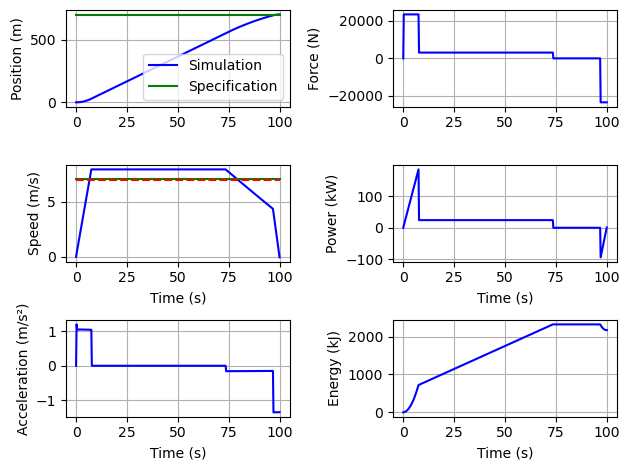

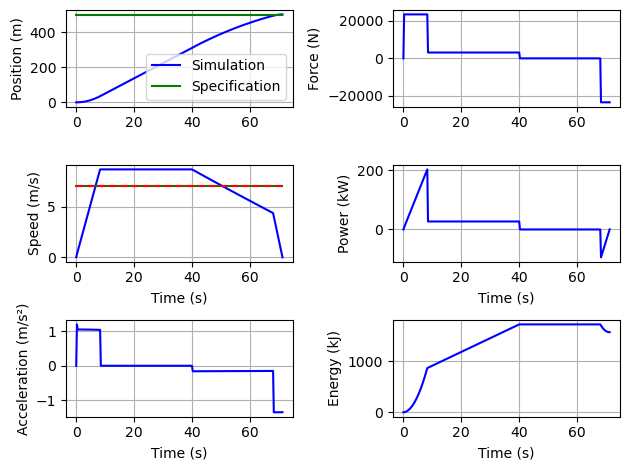

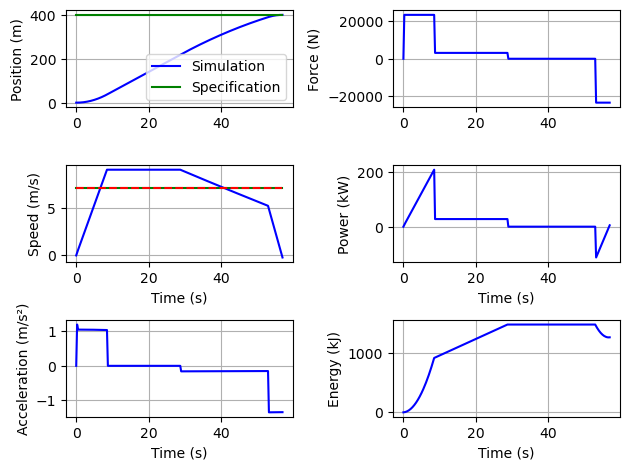

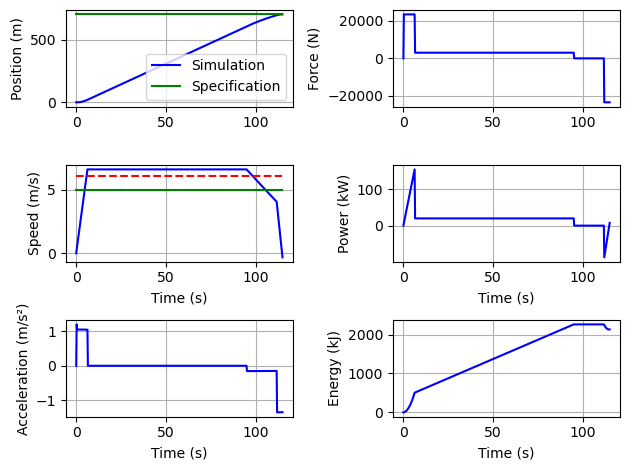

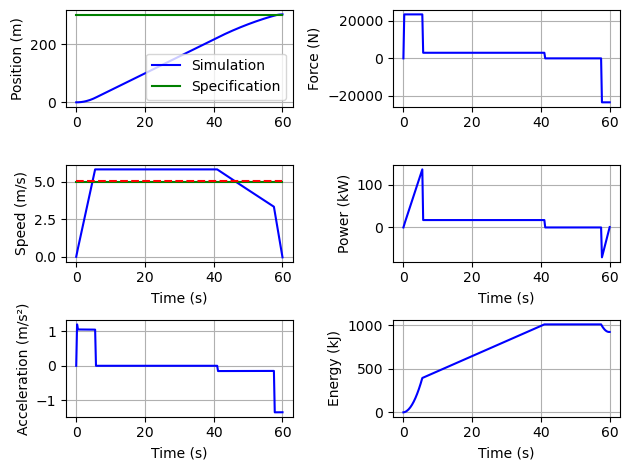

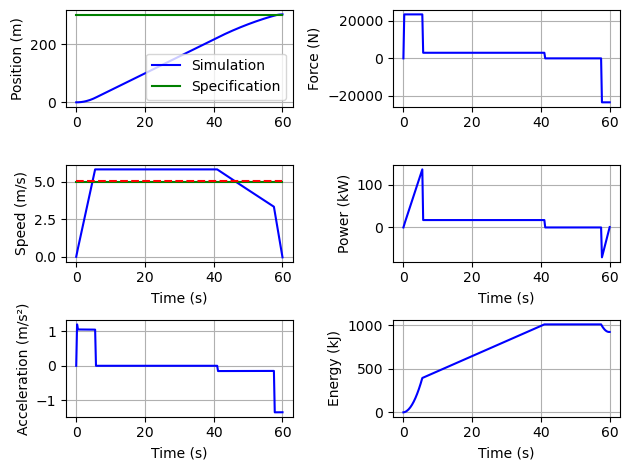

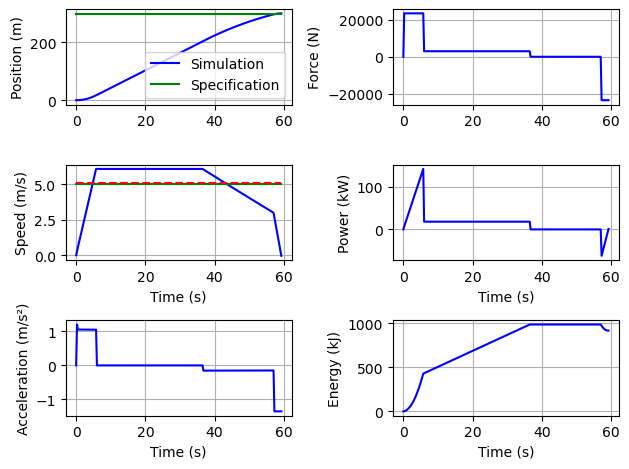

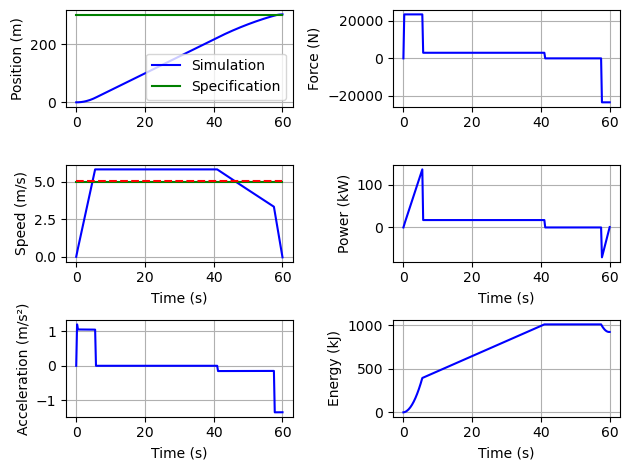

In [16]:
ToulouseC.optimLine()

In [17]:
ToulouseC.CalculPowerStorage()

0
1
2
3
4
5
6
7


In [6]:
omegaV=np.logspace(-5,2,50)
MassStorageV=[]
MassSC=[]
MassLFPAging=[]
MassLFPNRJ=[]
MassLFPPow=[]
CO2Total=[]

# Hypothese
Targetkm = 250e3 # [km] durée de vie du vehicule

# Energie massique des supercapacités
# https://1188159.fs1.hubspotusercontent-na1.net/hubfs/1188159/02-DS-220909-SKELCAP-CELLS-1F.pdf
# chez Skeleton
WmassSC=6.8*0.75 # [Wh/kg] on suppose pouvoir recuperer 75% de l'energie stockée
PmassSC=860/4.3*6.8*0.75 # [W/kg]

# Energie massique des batteries
# LFP
WmassLFP= 100 # [Wh/kg] les LFP peuvent pratiquement etre dechargé a 100%
PmassLFP=3*100 # [W/kg]  puissance massique en decharge à 6 C
PBmassLFP=1*100 # [W/kg]  puissance massique en decharge à 1 C
Ncycle = 3000 # [-] nb de cycle de decharge a 100%

# Bilan carbone
CO2SC = 39 # kgCO2eq/kg d'ecoInvent
CO2LFP = 11 # kgCO2eq/kg d'ecoInvent

for omega in omegaV:
    ToulouseC.FilterPower(omega)
    PmaxHF, PmaxLF, PmaxBrake, NRJHF, NRJLF = ToulouseC.IntegrateNRJ()
    
    Nc=Targetkm/ToulouseC.TotalLineDistance # Number of cycles for global lifetime 
    DoD=(Nc/3365)**(-1/2.26) # DoD calculation for Target Km
    MassStorageV = MassStorageV + [max(NRJHF/WmassSC*1e3, PmaxHF/PmassSC*1e3)
                                   +max(NRJLF/DoD/WmassLFP*1e3,
                                       PmaxLF/PmassLFP*1e3, PmaxBrake/PBmassLFP*1e3)] 
    MassSC = MassSC + [max(NRJHF/WmassSC*1e3, PmaxHF/PmassSC*1e3)] 
    MassLFPNRJ = MassLFPNRJ + [NRJLF/WmassLFP*1e3] 
    
    MassLFPAging = MassLFPAging + [NRJLF/DoD/WmassLFP*1e3] 
    MassLFPPow = MassLFPPow + [PmaxBrake/PBmassLFP*1e3]
    CO2Total = CO2Total + [max(NRJHF/WmassSC*1e3, PmaxHF/PmassSC*1e3)*CO2SC+
                           max(NRJLF/DoD/WmassLFP*1e3, PmaxLF/PmassLFP*1e3, PmaxBrake/PBmassLFP*1e3)*CO2LFP]


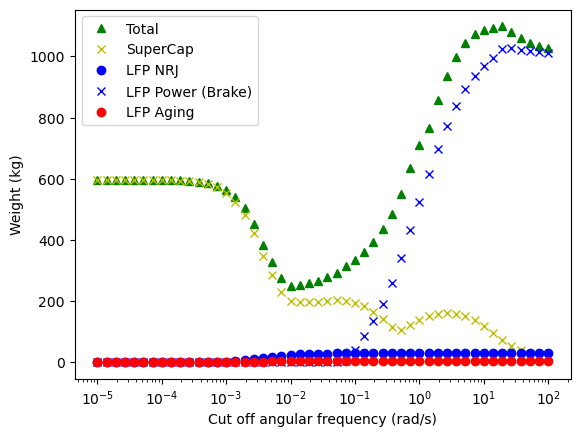

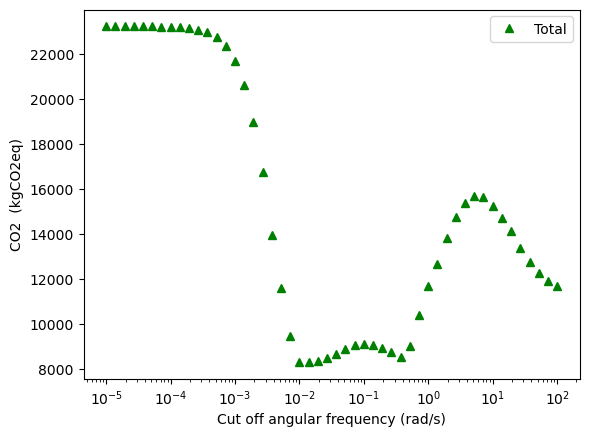

In [7]:

plt.plot(omegaV, MassStorageV, 'g^', label='Total')
plt.plot(omegaV, MassSC, 'yx', label='SuperCap')
plt.plot(omegaV, MassLFPNRJ, 'bo', label='LFP NRJ')
plt.plot(omegaV, MassLFPPow, 'bx', label='LFP Power (Brake)')
plt.plot(omegaV, MassLFPAging, 'ro', label='LFP Aging')
plt.xscale('log') 
plt.ylabel('Weight (kg)')
plt.xlabel('Cut off angular frequency (rad/s)')
plt.legend()
plt.show()
plt.plot(omegaV, CO2Total, 'g^', label='Total')
plt.xscale('log') 
plt.ylabel('CO2  (kgCO2eq)')
plt.xlabel('Cut off angular frequency (rad/s)')
plt.legend()
plt.show()

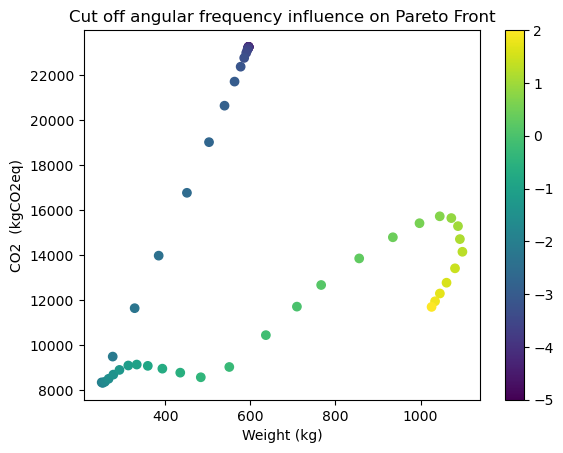

In [8]:
# Pareto Front

plt.scatter(MassStorageV, CO2Total, c=np.log10(omegaV))
plt.xlabel('Weight (kg)')
plt.ylabel('CO2  (kgCO2eq)')
plt.colorbar()
plt.title('Cut off angular frequency influence on Pareto Front')
plt.show()

In [ ]:
omegaV

Super Capacitor:
Pmax: 113.13 kW
NRJ:  0.22 kWh
Mass:  110.9 kg
---
Traction battery:
Pmax discharge: 110.12 kW
Pmax charge: 29.84 kW
NRJ: 78.27 kWh
Mass:  298.4 kg
---


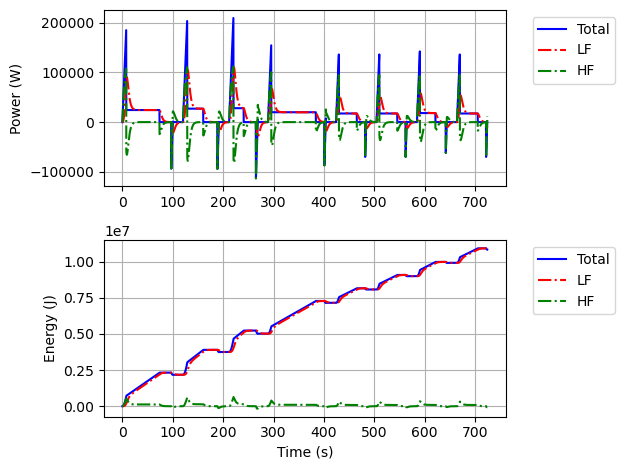

In [23]:
ToulouseC.FilterPower(0.4)
PmaxHF, PmaxLF, PmaxBrakeLF, NRJHF, NRJLF=ToulouseC.IntegrateNRJ()

Nc=Targetkm/ToulouseC.TotalLineDistance # Number of cycles for global lifetime 
DoD=(Nc/3365)**(-1/2.26) # DoD calculation for Target Km

print("Super Capacitor:")
print("Pmax: %.2f kW"%PmaxHF)
print("NRJ:  %.2f kWh"%NRJHF)
print("Mass: % .1f kg"%(max(NRJHF/WmassSC*1e3, PmaxHF/PmassSC*1e3)))
      
print("---")
print("Traction battery:")
print("Pmax discharge: %.2f kW"%PmaxLF)
print("Pmax charge: %.2f kW"%PmaxBrakeLF)
print("NRJ: %.2f kWh"%max(NRJLF, NRJLFAging*Targetkm/Ncycle))
print("Mass: % .1f kg"%(max(NRJLF/DoD/WmassLFP*1e3,
                                       PmaxLF/PmassLFP*1e3, PmaxBrakeLF/PBmassLFP*1e3)))      

ToulouseC.plot()
print("---")

In [ ]:
print(ToulouseC.IntegrateNRJ())

In [ ]:
print(ToulouseC.IntegrateNRJ())

### Energy storage system specification


> Jaafar, A., Sareni, B., Roboam, X., & Thiounn-Guermeur, M. (2010, September). Sizing of a hybrid locomotive based on accumulators and ultracapacitors. In 2010 IEEE Vehicle Power and Propulsion Conference (pp. 1-6). IEEE.

In [ ]:
omega=0.5
TF=signal.TransferFunction([1], [1/omega**2, 2*1/omega, 1])

In [ ]:
Y = signal.lsim(TF, ToulouseC.PowerStorage , ToulouseC.GlobalTime)

In [ ]:
Y

In [ ]:
len(ToulouseC.GlobalTime)

In [ ]:
A=[700,500,400,700,300,300,300,300,300]

In [ ]:
sum(A)

http://www.devon-company.com/spec/32650%20LiFePO4%20Battery%20Spec.pdf
    

https://5.imimg.com/data5/SELLER/Doc/2021/3/VO/ZR/QG/86781150/3-2-v-10-ah-lifepo4-prismatic-cell.pdf
    